In [97]:
# used  https://github.com/Gaurav927/Neural_Style_Transfer/blob/master/Style_Transfer.ipynb as a start.

%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [98]:
# get the "features" portion of VGG19
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

c:\Users\11730\OneDrive\桌面\420a2\a2dataset\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [99]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [100]:
# Each layer in architecture is named by integers
for name, layer in vgg._modules.items():
    print(name ,layer)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)

In [101]:
# Helper function to load images
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
   
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [102]:

# load in content and style image
content = load_image('content.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('style.jpg', shape=content.shape[-2:]).to(device)

In [103]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

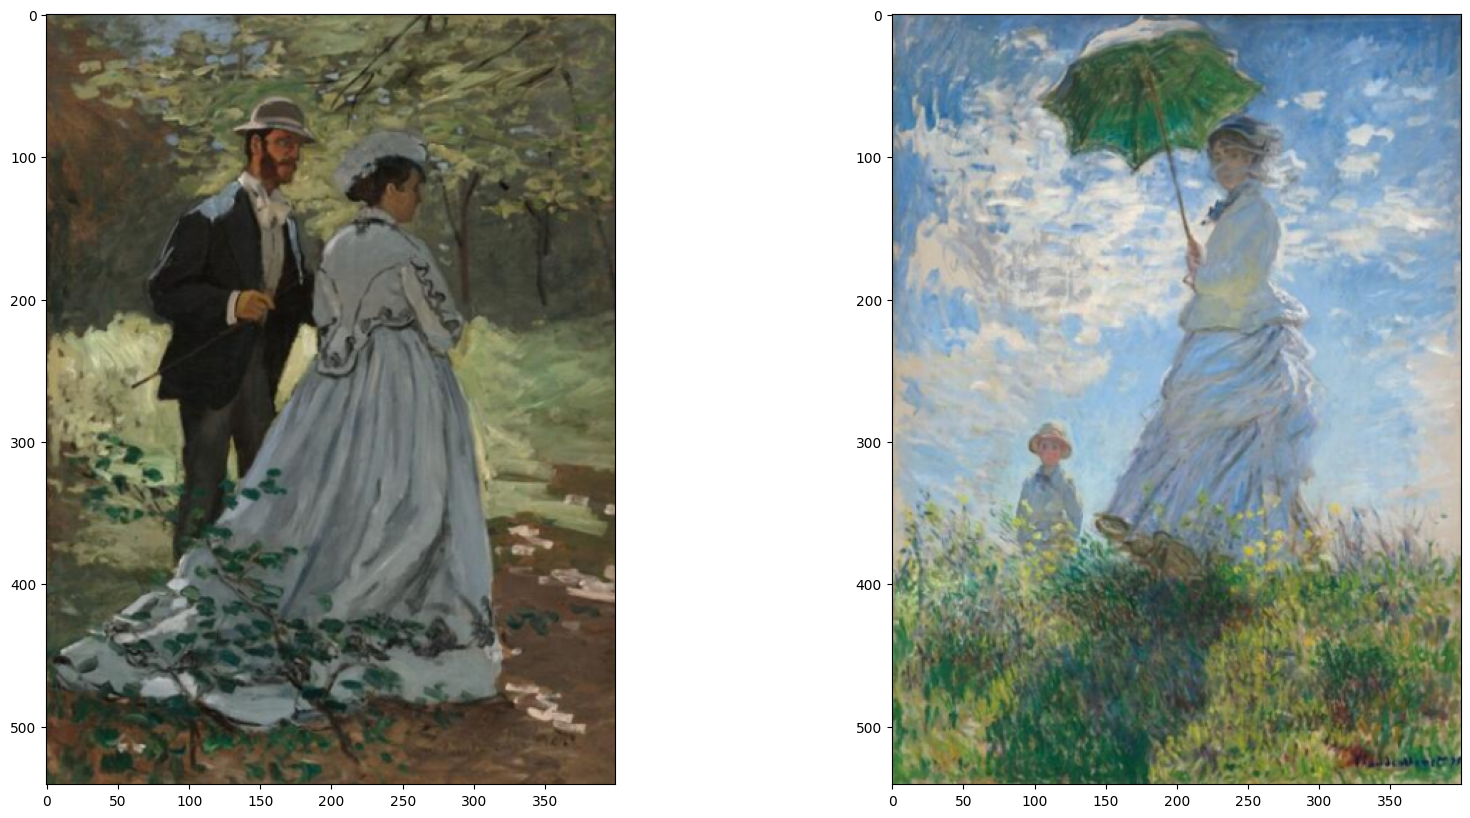

In [104]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [105]:
layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

def get_features(image, model):
    
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [106]:
def gram_matrix(tensor):
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [107]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [108]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

In [109]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from  target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

KeyboardInterrupt: 

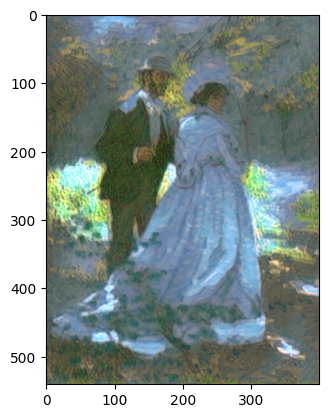

In [ ]:
plt.imshow(im_convert(target))

In [ ]:
plt.savefig('target.jpg')

<Figure size 640x480 with 0 Axes>

#MobileNet



In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import copy


In [111]:
# Load MobileNet V2
mobilenet = models.mobilenet_v2(pretrained=True).features.to(device)
mobilenet.eval()  # Set the network to evaluation mode

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [112]:
for idx, module in enumerate(mobilenet.children()):
    print(f'Block {idx}: {module}')


Block 0: Conv2dNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)
Block 1: InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Block 2: InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2

#investigate layers


In [113]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

for b_idx in range(0,18):
    mobilenet[b_idx].register_forward_hook(get_activation(f'block{b_idx}'))




In [114]:
from torchvision import transforms
from PIL import Image

# Image transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load image
img = Image.open("content.jpg")
img_t = preprocess(img).unsqueeze(0).to(device)

# Forward pass
output = mobilenet(img_t)


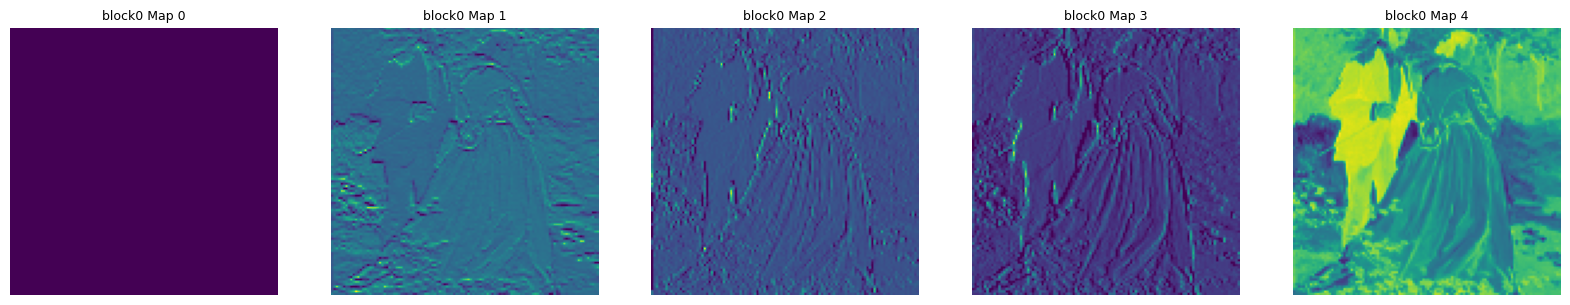

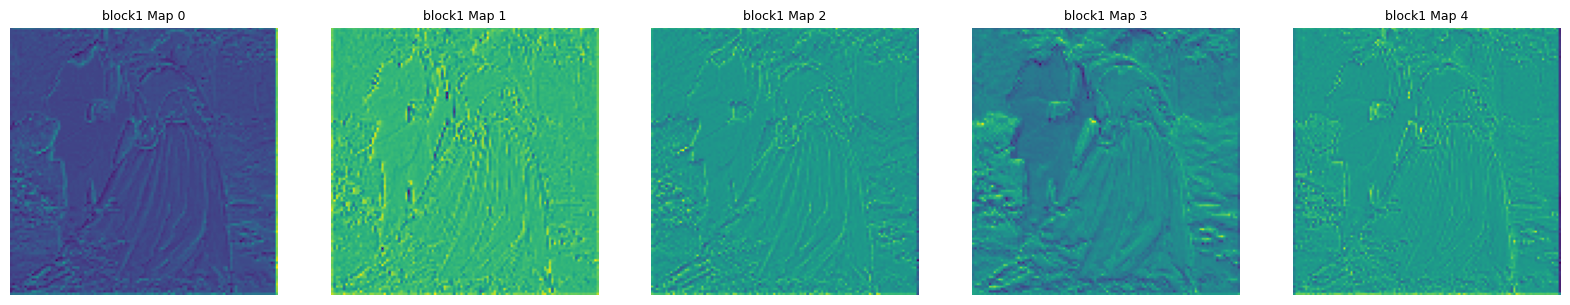

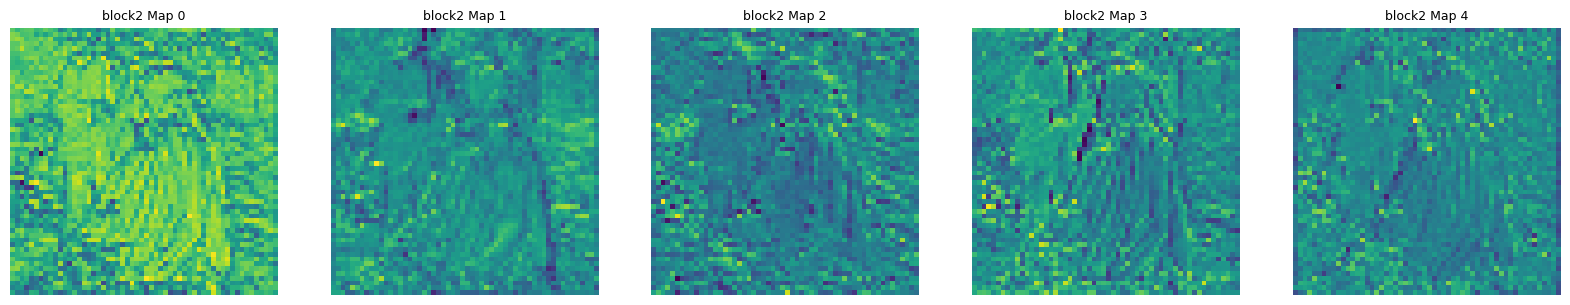

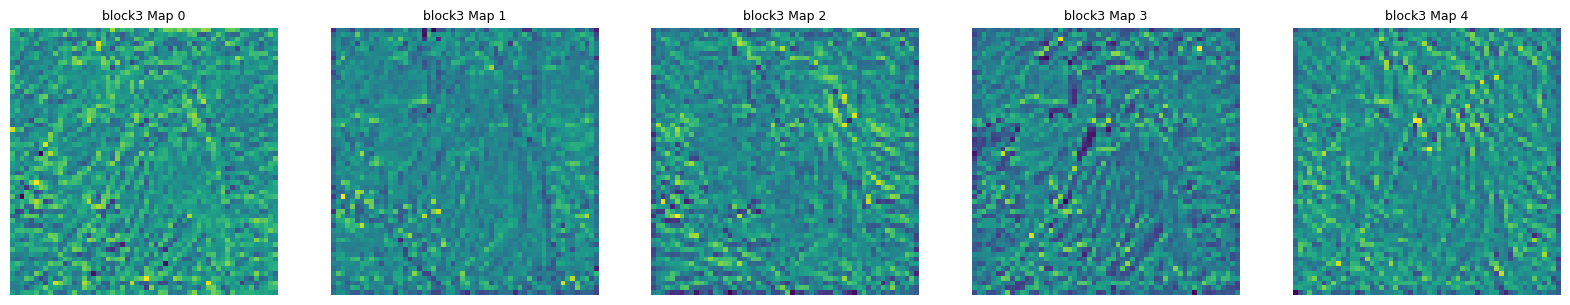

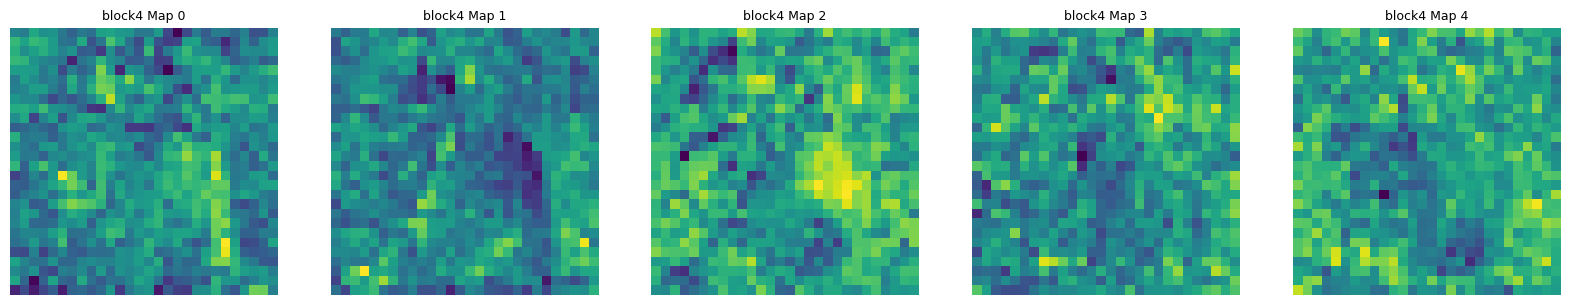

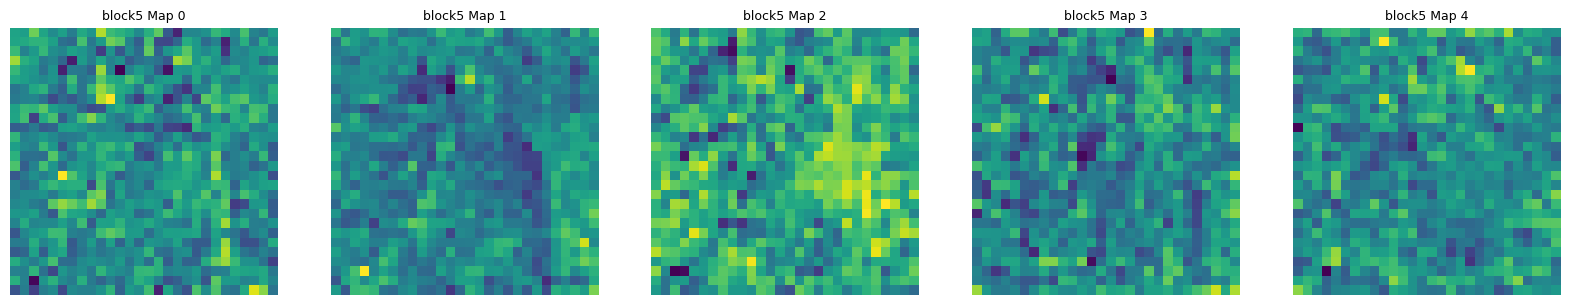

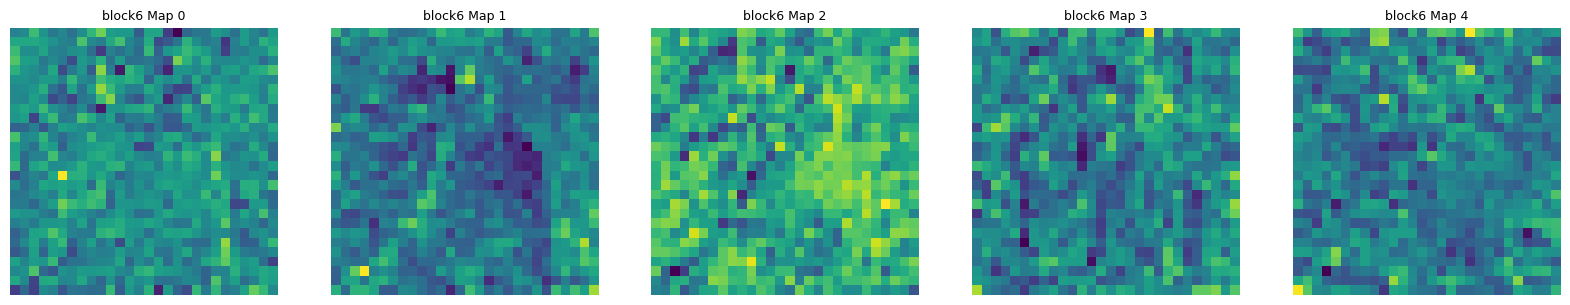

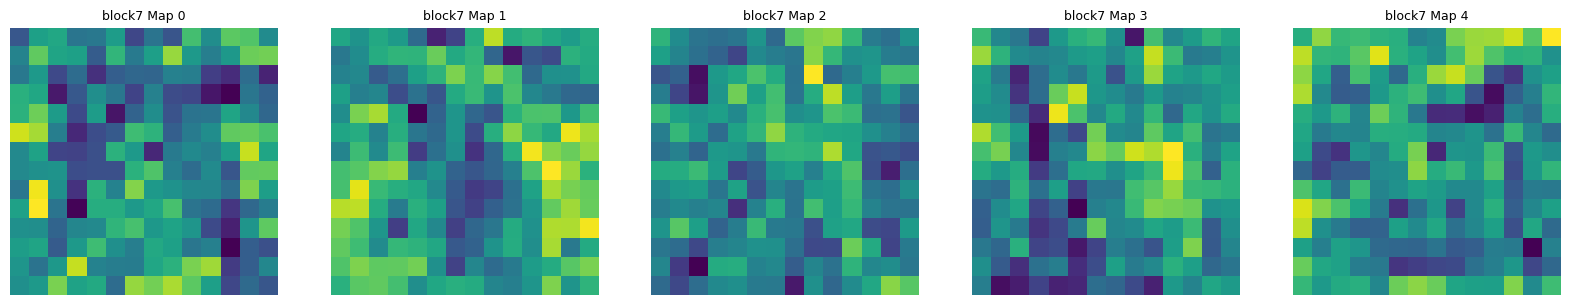

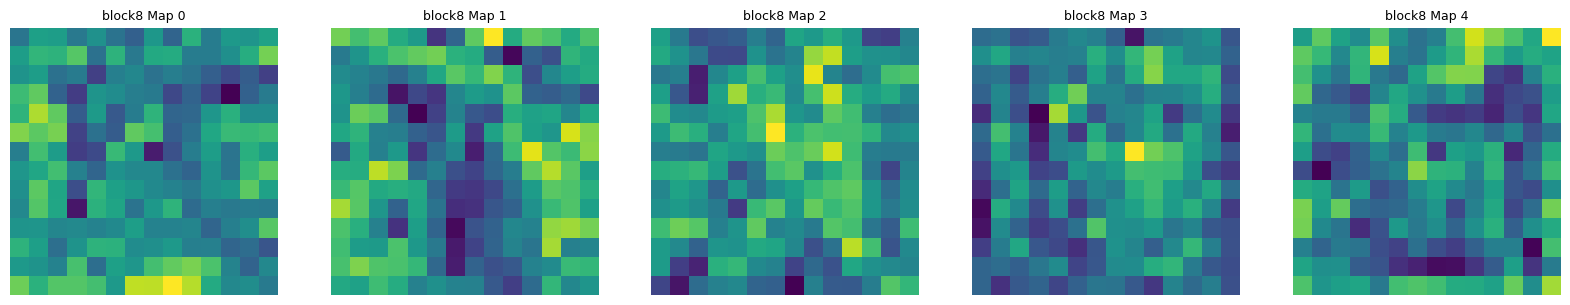

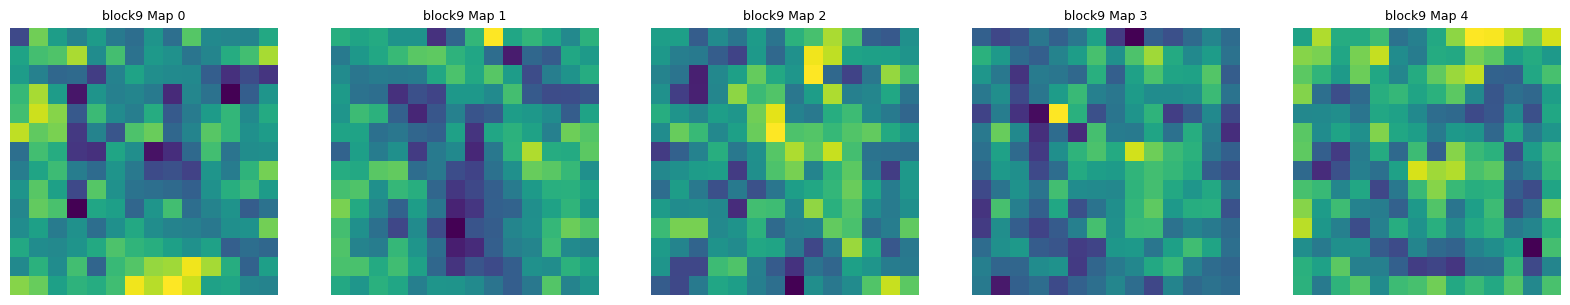

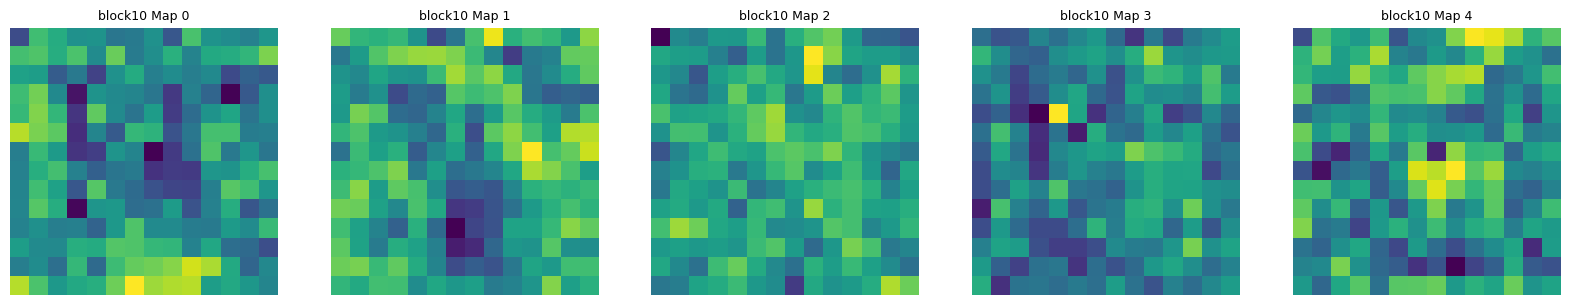

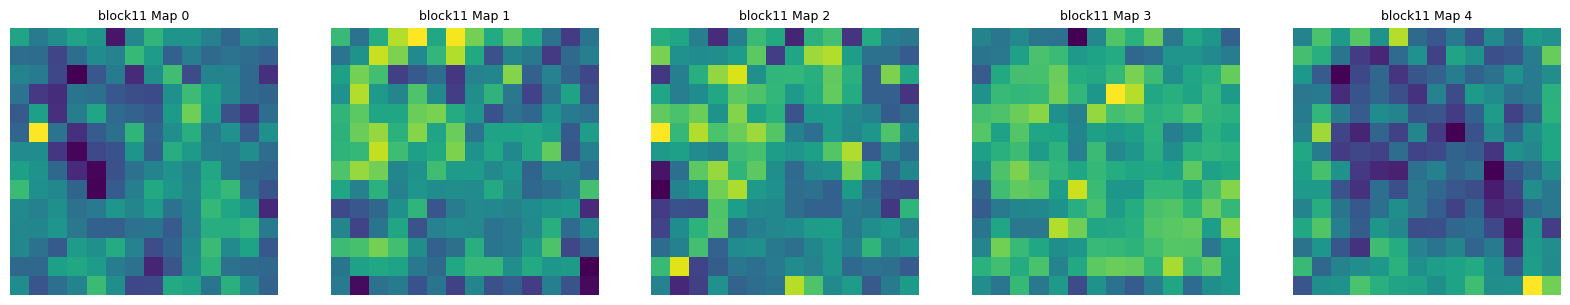

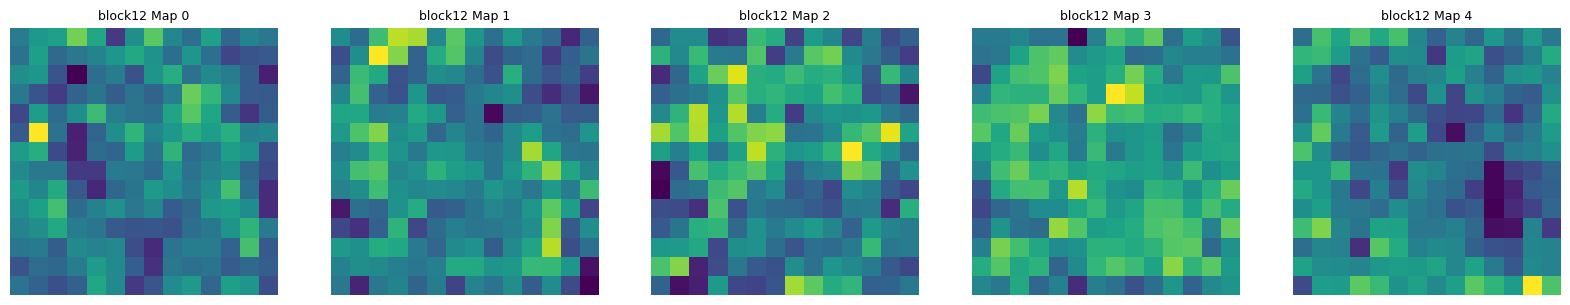

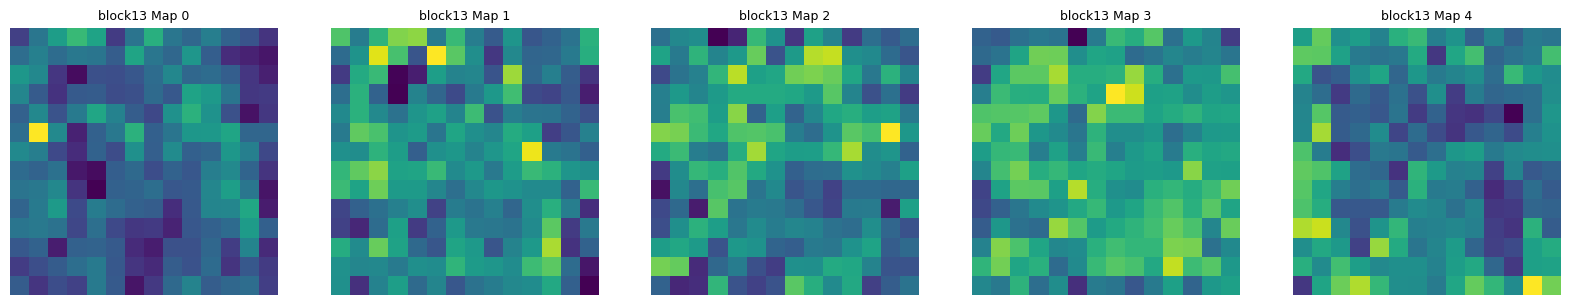

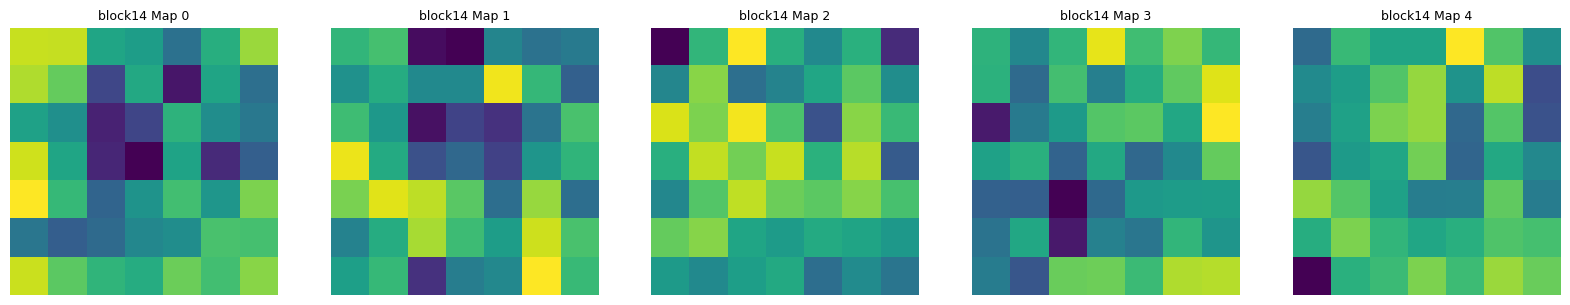

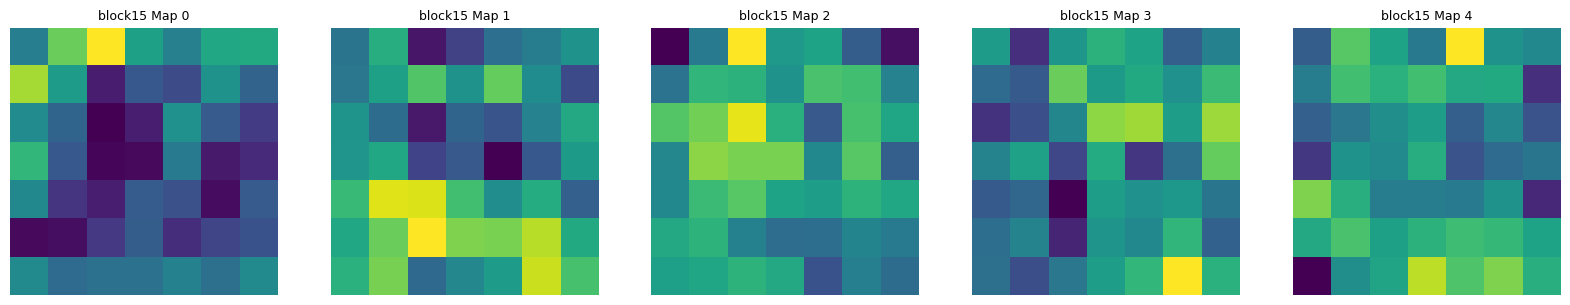

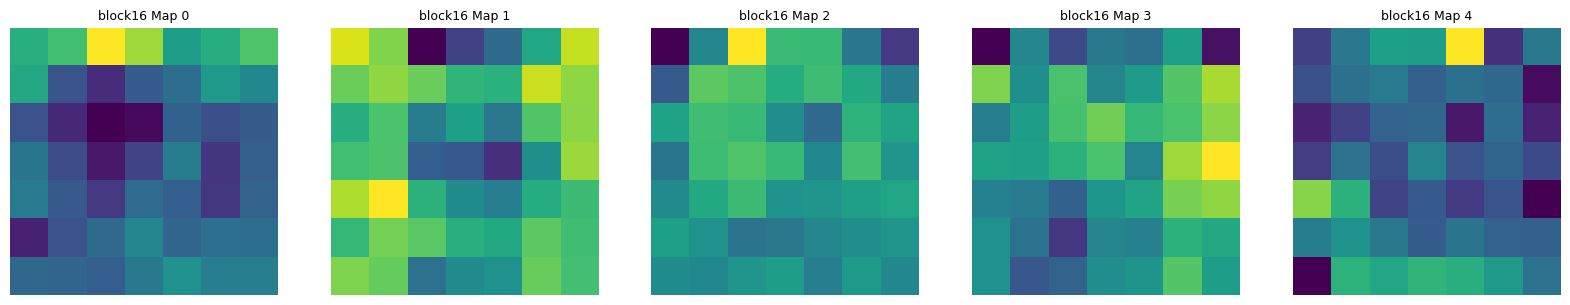

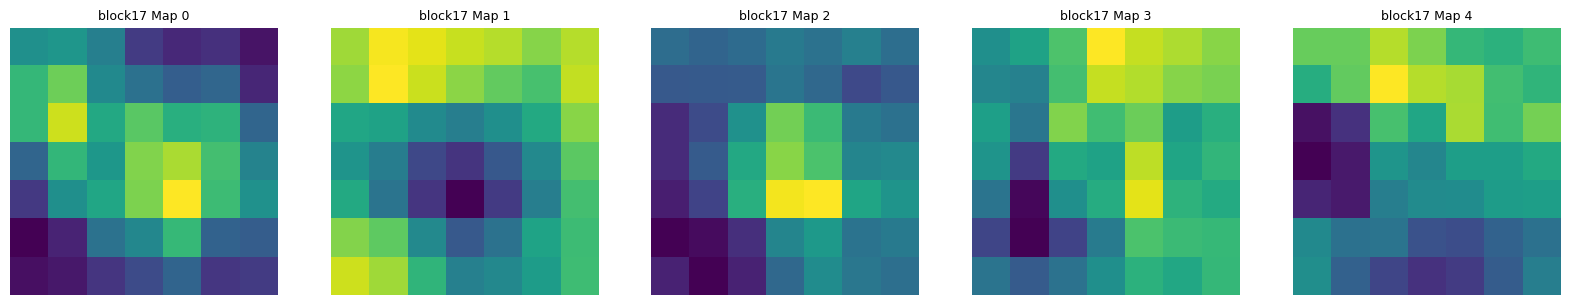

In [115]:
def plot_activations_with_labels(activations, num_maps=10, cols=5):
    for name, act in activations.items():
        fig, axes = plt.subplots(1, num_maps, figsize=(20, 10))
        for i, ax in enumerate(axes.flat):
            if i < act.size(1):
                ax.imshow(act[0, i].cpu().numpy(), cmap='viridis')
                ax.set_title(f'{name} Map {i}', fontsize=9)
                ax.axis('off')
            else:
                ax.set_visible(False)
        plt.show()

plot_activations_with_labels(activations, num_maps=5, cols=5)


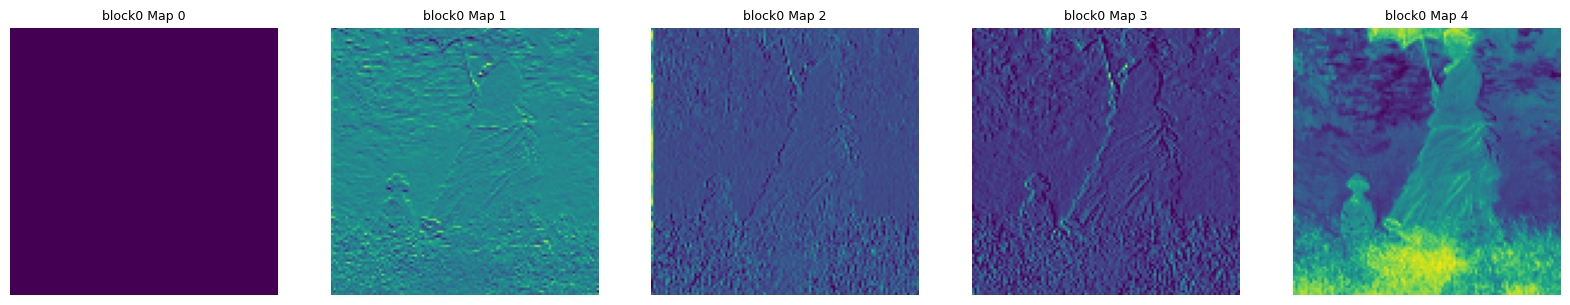

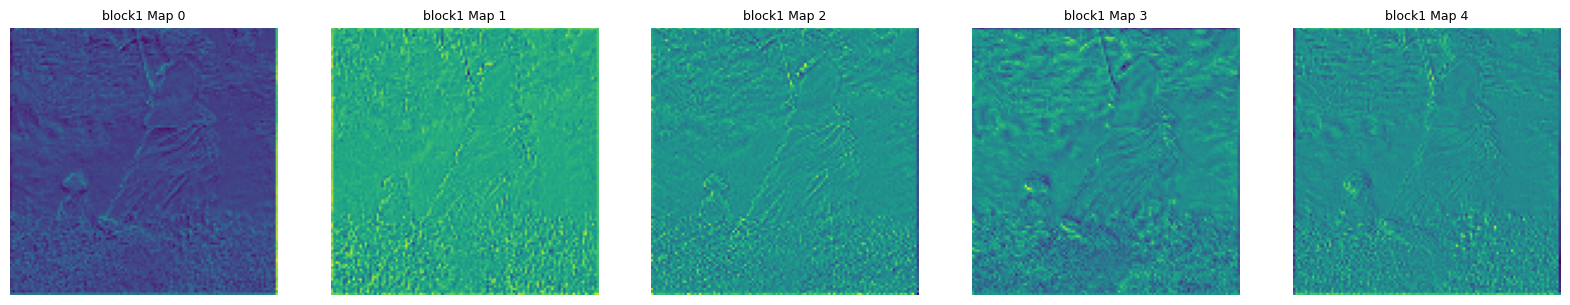

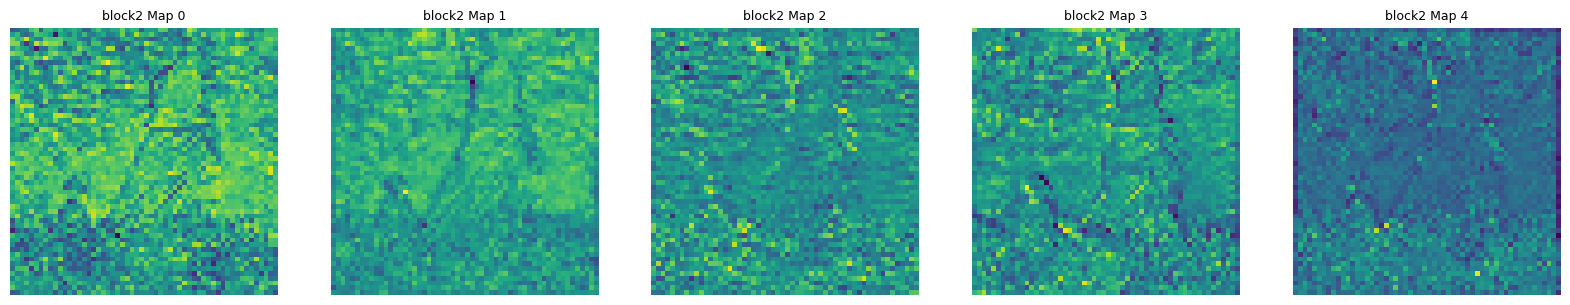

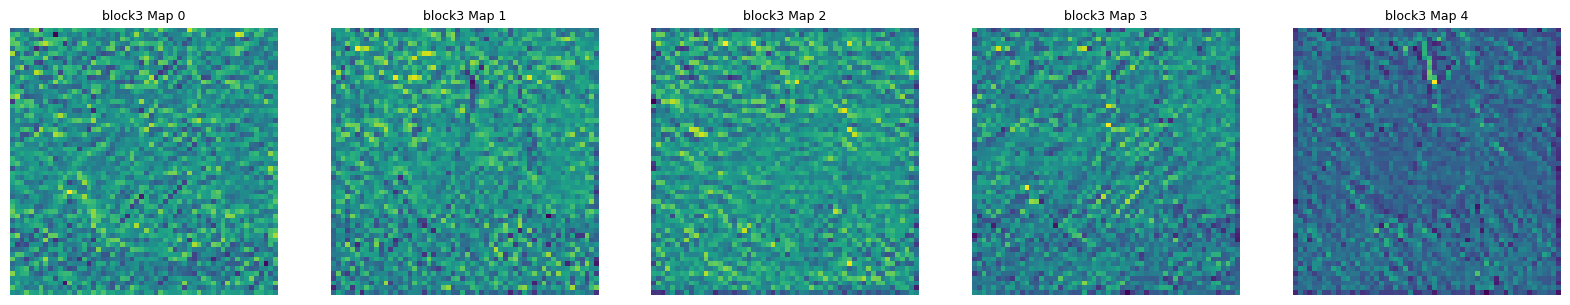

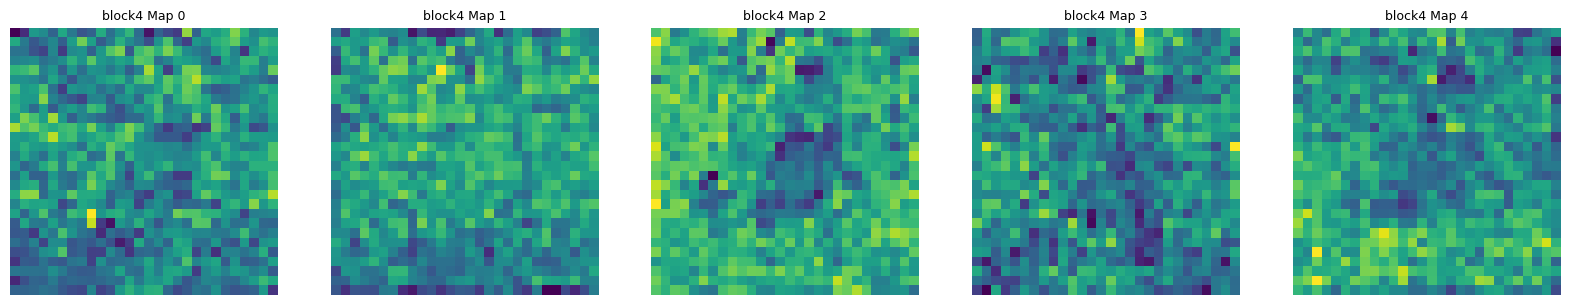

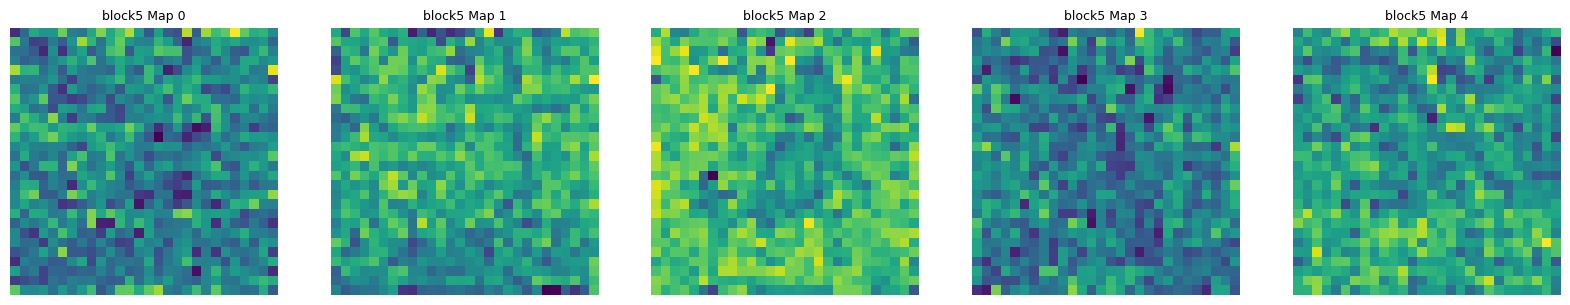

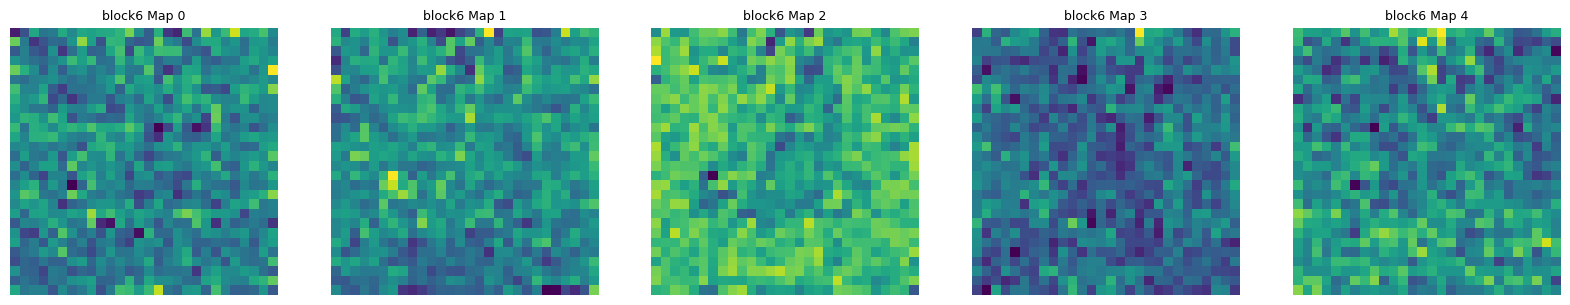

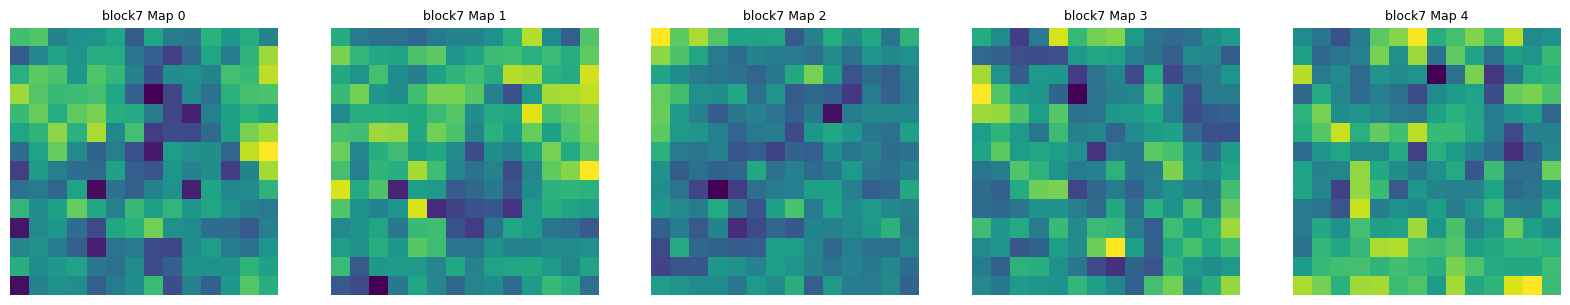

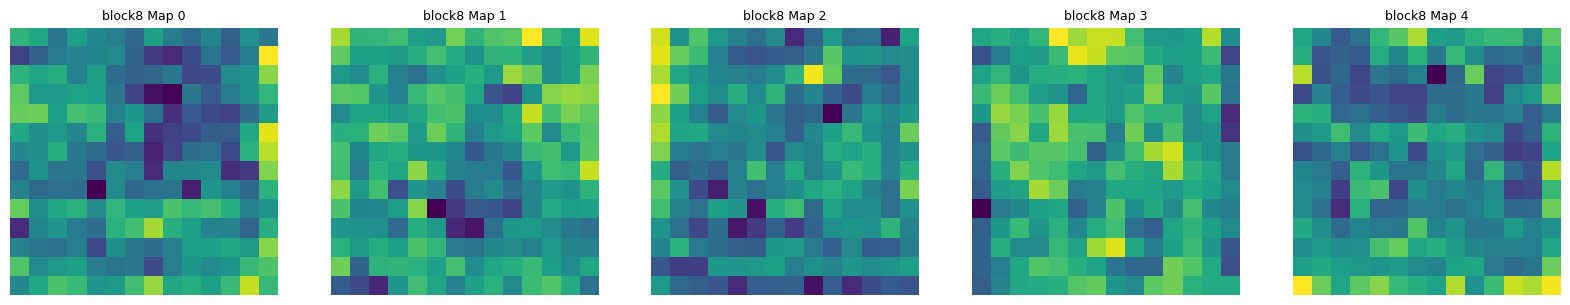

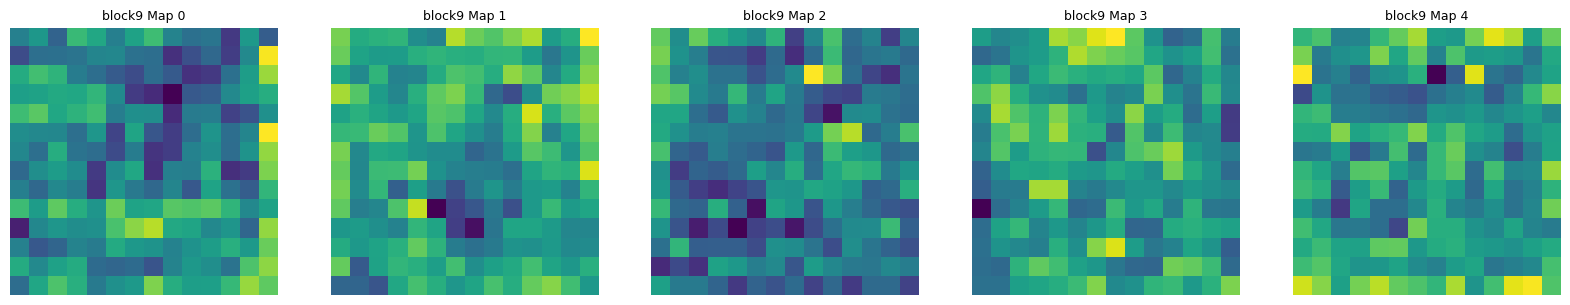

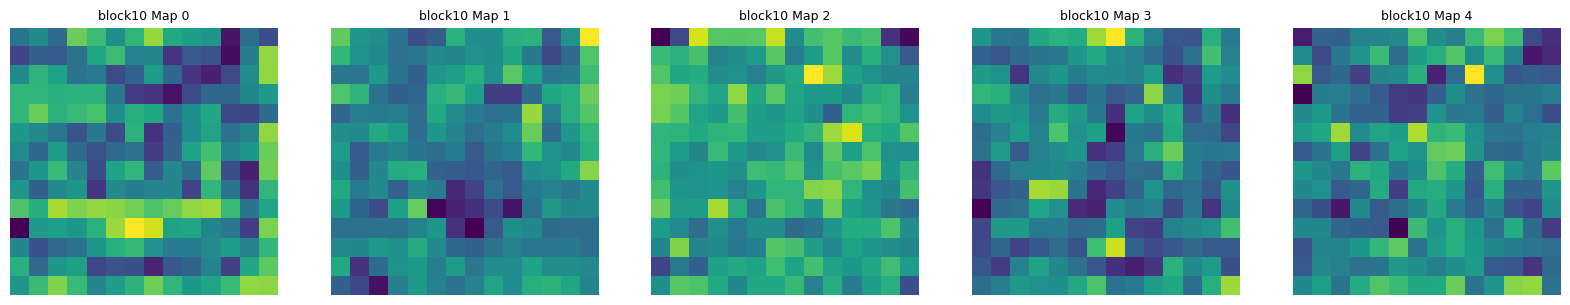

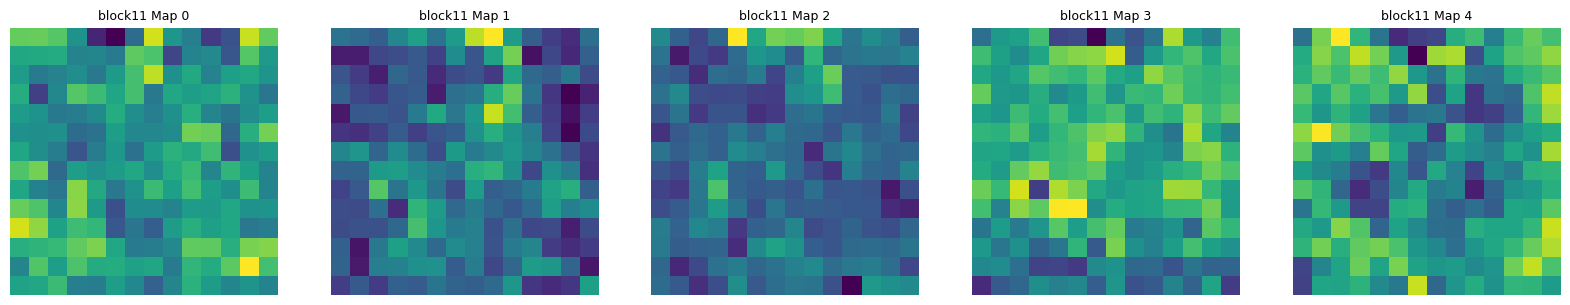

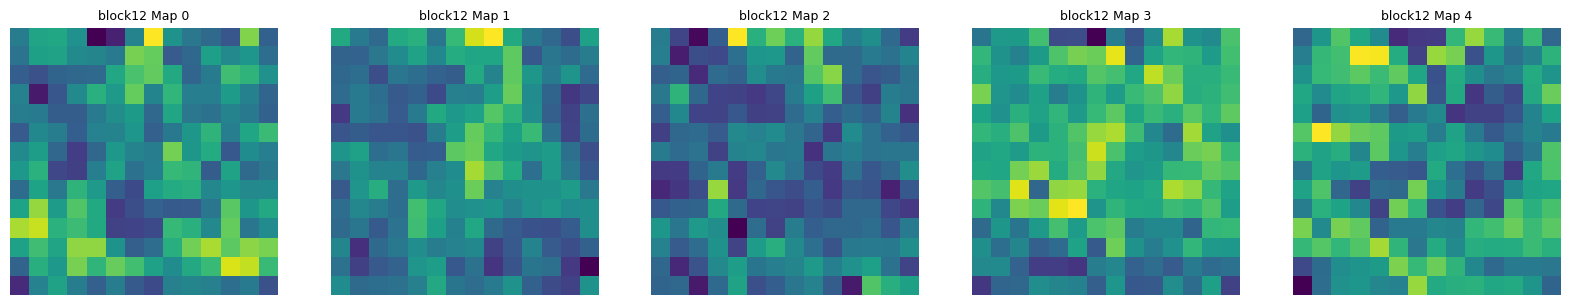

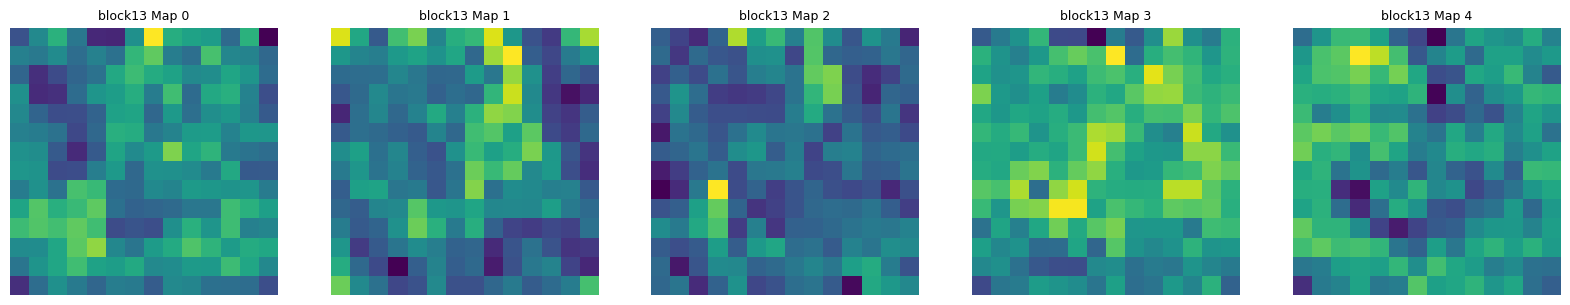

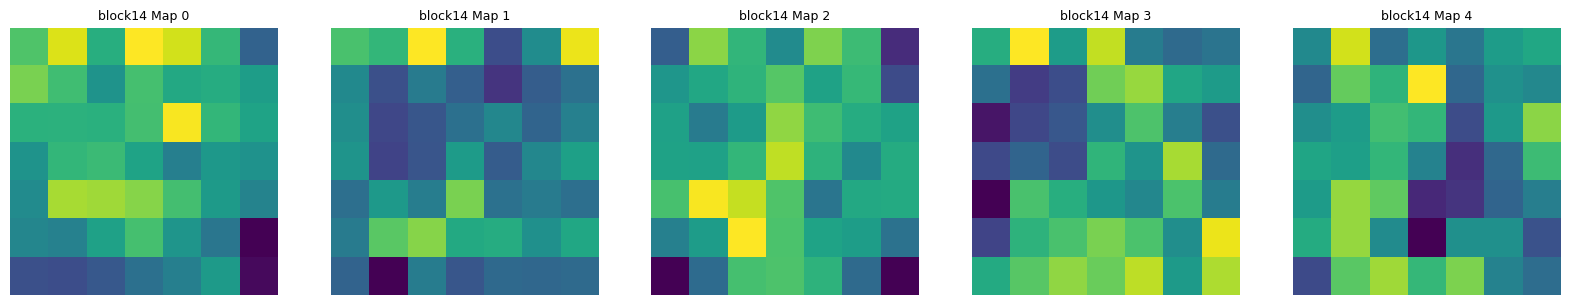

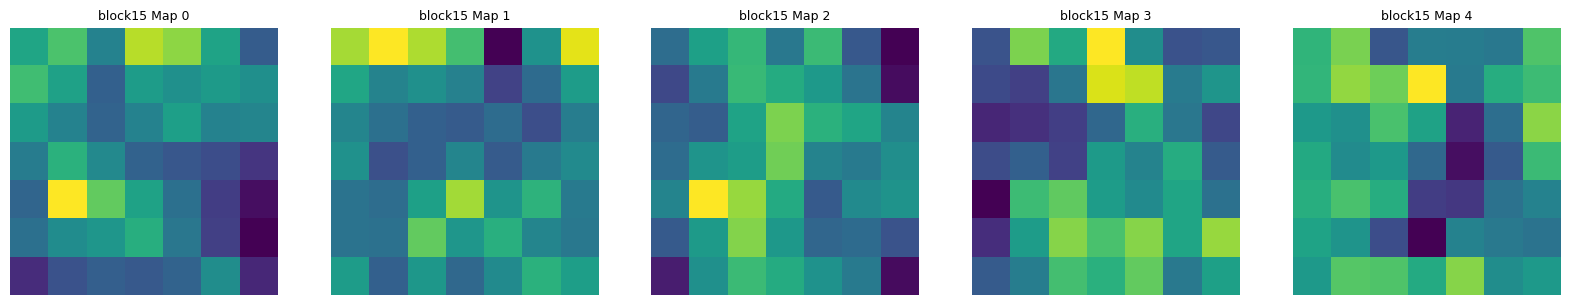

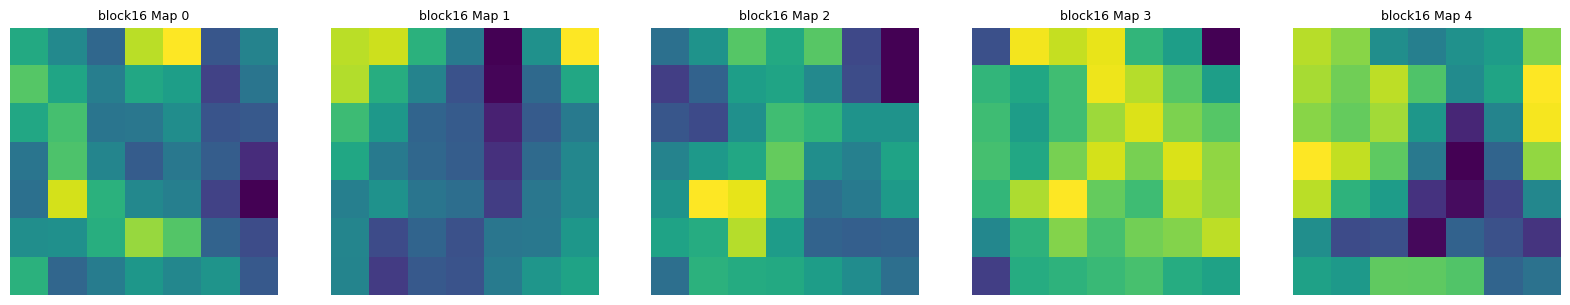

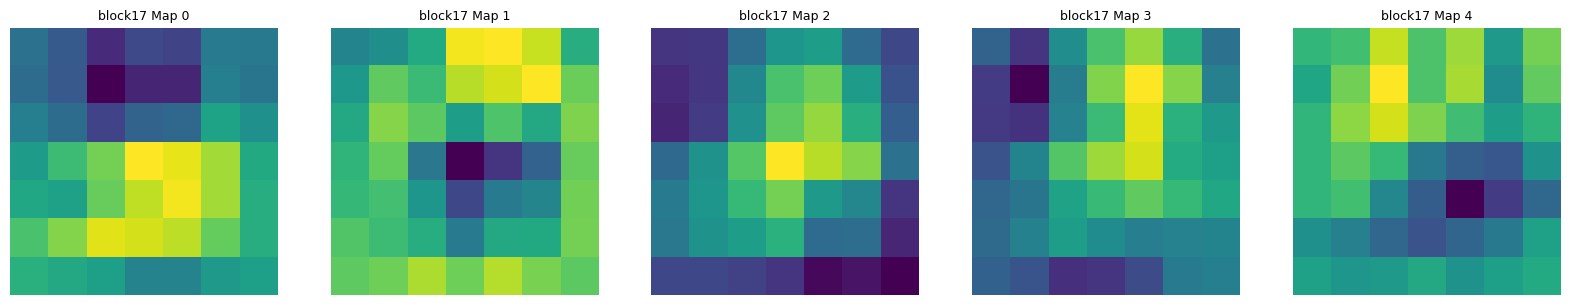

In [116]:
# Load image
img = Image.open("style.jpg")
img_t = preprocess(img).unsqueeze(0).to(device)

# Forward pass
output = mobilenet(img_t)
plot_activations_with_labels(activations, num_maps=5, cols=5)